In [1]:
import json
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.preprocessing import image
import pathlib
import pandas as pd
from PIL import Image 
from PIL.ImageDraw import Draw
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [2]:
categories = ['with_mask', 'without_mask']

f = open ('annotations.json', "r")

data = json.loads(f.read())

images  = []    # Les images d'origine
images_boxes = [] # Les images selectionnées 
targets = []    # Les coordonnées des boxes 
labels  = []    # Les catégories des boxes  
filenames = []  # Les chemins des images
#test_filenames = []


width = 180
height = 180
num_classes = len(categories)



In [3]:
# Récupérer les données depuis le json (ie les informations sur les boxes)
def load_data():
    global images, targets, labels, filenames, test_filenames,images_boxes
    
    images = []
    targets = []
    labels = []
    filenames = []
    images_boxes = []
    #test_filenames = []


    for i in data['data']:
        path = i['image']['path']
        we, he = Image.open(path).size # largeur et hauteur de l'image d'origine
        img = image.load_img(path,target_size=(width,height)) #L'image d'origine en taille 180/180
        img_arr = image.img_to_array(img)
        #img_arr = tf.expand_dims(img, axis=0)

        for j in i['image']['boxes']:  # On regarde les boxes correspondantes à l'image d'origine
            if(len(j)!=1):
                w = int(j['width'])
                h = int(j['height'])
                               
                category = j['category']
                
                name = j['name'].split('-')
                
                coords = name[2].split('x')

                xmin = float(coords[0]) 
                ymin = float(coords[1]) 
                xmax = float(xmin + w)  
                ymax = float(ymin + h)   

                path_box = j['path']
                
                width_box, height_box = Image.open(path_box).size
                image_selected = image.load_img(path_box,target_size=(width_box,height_box))
                image_selected_arr = image.img_to_array(image_selected)
                               
                              
                images = images + [img_arr]
                x = (xmin/we, ymin/he, xmax/we, ymax/he) # on réduit les coordonées à l'intervalle [0,1]
                targets = targets + [x]
                labels = labels + [categories.index(category)]
                filenames.append(path)
                #test_filenames.append(pathb)
                images_boxes.append(image_selected_arr)



load_data()
#print(images)
#print(targets)
#print(labels)
#print(filenames)
#print(images_boxes)

In [7]:
train_images =  np.array(images_boxes[10:50]+images_boxes[60:100])
train_targets = np.array(targets[10:50]+targets[60:100])
train_labels =  np.array(labels[10:50]+labels[60:100])
train_filenames = np.array(filenames[10:50]+filenames[60:100])

validation_images =  np.array(images_boxes[0:10]+images_boxes[50:60])
validation_targets = np.array(targets[0:10]+targets[50:60])
validation_labels =  np.array(labels[0:10]+labels[50:60])
validation_filenames = np.array(filenames[0:10]+filenames[50:60])

In [9]:
input_shape = (height, width, 3)
input_layer = tf.keras.layers.Input(input_shape)
#create the base layers

base_layers = layers.experimental.preprocessing.Rescaling(1./255, name='bl_1')(input_layer)
base_layers = layers.Conv2D(16, 3, padding='same', activation='relu', name='bl_2')(base_layers)
base_layers = layers.MaxPooling2D(name='bl_3')(base_layers)
base_layers = layers.Conv2D(32, 3, padding='same', activation='relu', name='bl_4')(base_layers)
base_layers = layers.MaxPooling2D(name='bl_5')(base_layers)
base_layers = layers.Conv2D(64, 3, padding='same', activation='relu', name='bl_6')(base_layers)
base_layers = layers.MaxPooling2D(name='bl_7')(base_layers)
base_layers = layers.Flatten(name='bl_8')(base_layers)
base_layers = layers.Dropout(0.5)(base_layers)

classifier_branch = layers.Dense(128, activation='relu', name='cl_1')(base_layers)
classifier_branch = layers.Dense(num_classes, name='cl_head')(classifier_branch)  

locator_branch = layers.Dense(128, activation='relu', name='bb_1')(base_layers)
locator_branch = layers.Dense(64, activation='relu', name='bb_2')(locator_branch)
locator_branch = layers.Dense(32, activation='relu', name='bb_3')(locator_branch)
locator_branch = layers.Dense(4, activation='sigmoid', name='bb_head')(locator_branch)

#classifier_branch = layers.Dense(128, activation='relu', name='cl_1')(locator_branch)
#classifier_branch = layers.Dense(num_classes, name='cl_head')(classifier_branch)  


model = tf.keras.Model(input_layer,
           outputs=[classifier_branch,locator_branch])


losses = {"cl_head":tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), "bb_head":tf.keras.losses.MSE}
    
model.compile(loss=losses, optimizer='Adam', metrics=['accuracy'])
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 bl_1 (Rescaling)               (None, 180, 180, 3)  0           ['input_2[0][0]']                
                                                                                                  
 bl_2 (Conv2D)                  (None, 180, 180, 16  448         ['bl_1[0][0]']                   
                                )                                                                 
                                                                                            

In [11]:
trainTargets = {
    "cl_head": train_labels,
    "bb_head": train_targets
}
validationTargets = {
    "cl_head": validation_labels,
    "bb_head": validation_targets
}

history = model.fit(train_images, trainTargets,
             validation_data=(validation_images, validationTargets),
             batch_size=32,
             epochs=50,
             shuffle=True,
             verbose=1)

Epoch 1/50
3/3 [==============================] - 2s 795ms/step - loss: 0.0062 - cl_head_loss: 6.4878e-05 - bb_head_loss: 0.0061 - cl_head_accuracy: 1.0000 - bb_head_accuracy: 0.8750 - val_loss: 0.1103 - val_cl_head_loss: 0.0832 - val_bb_head_loss: 0.0271 - val_cl_head_accuracy: 0.9500 - val_bb_head_accuracy: 0.9000
Epoch 2/50
3/3 [==============================] - 2s 713ms/step - loss: 0.0063 - cl_head_loss: 6.7406e-05 - bb_head_loss: 0.0063 - cl_head_accuracy: 1.0000 - bb_head_accuracy: 0.8750 - val_loss: 0.1105 - val_cl_head_loss: 0.0792 - val_bb_head_loss: 0.0314 - val_cl_head_accuracy: 0.9500 - val_bb_head_accuracy: 0.5500
Epoch 3/50
3/3 [==============================] - 2s 705ms/step - loss: 0.0066 - cl_head_loss: 8.2150e-05 - bb_head_loss: 0.0065 - cl_head_accuracy: 1.0000 - bb_head_accuracy: 0.8750 - val_loss: 0.1138 - val_cl_head_loss: 0.0870 - val_bb_head_loss: 0.0268 - val_cl_head_accuracy: 0.9500 - val_bb_head_accuracy: 0.8500
Epoch 4/50
3/3 [==============================

Epoch 27/50
3/3 [==============================] - 2s 714ms/step - loss: 0.0047 - cl_head_loss: 9.6501e-05 - bb_head_loss: 0.0046 - cl_head_accuracy: 1.0000 - bb_head_accuracy: 0.9000 - val_loss: 0.1278 - val_cl_head_loss: 0.1031 - val_bb_head_loss: 0.0246 - val_cl_head_accuracy: 0.9500 - val_bb_head_accuracy: 0.8000
Epoch 28/50
3/3 [==============================] - 2s 682ms/step - loss: 0.0041 - cl_head_loss: 8.0802e-05 - bb_head_loss: 0.0040 - cl_head_accuracy: 1.0000 - bb_head_accuracy: 0.9250 - val_loss: 0.1209 - val_cl_head_loss: 0.0950 - val_bb_head_loss: 0.0259 - val_cl_head_accuracy: 0.9500 - val_bb_head_accuracy: 0.7500
Epoch 29/50
3/3 [==============================] - 2s 705ms/step - loss: 0.0039 - cl_head_loss: 7.1365e-05 - bb_head_loss: 0.0039 - cl_head_accuracy: 1.0000 - bb_head_accuracy: 0.9375 - val_loss: 0.1249 - val_cl_head_loss: 0.1023 - val_bb_head_loss: 0.0227 - val_cl_head_accuracy: 0.9500 - val_bb_head_accuracy: 0.9000
Epoch 30/50
3/3 [==========================

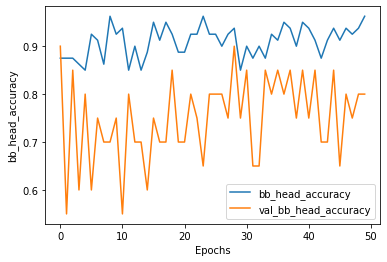

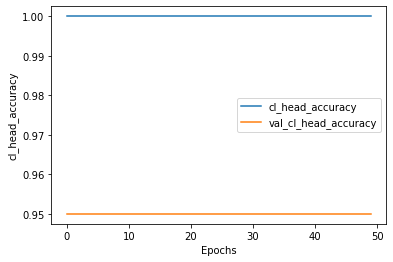

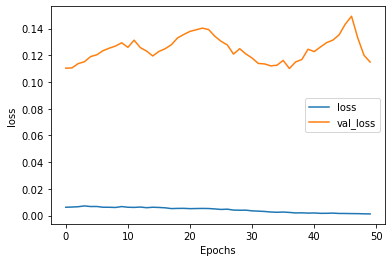

In [13]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "bb_head_accuracy")
plot_graphs(history, "cl_head_accuracy")
plot_graphs(history, "loss")

../img/resized/with_mask/image0.png
with_mask 99 %


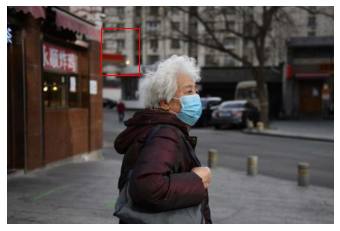

../img/resized/with_mask/image1.png
with_mask 100 %


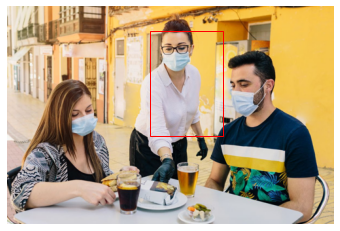

../img/resized/with_mask/image10.png
with_mask 100 %


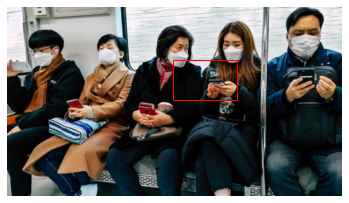

../img/resized/with_mask/image11.png
with_mask 100 %


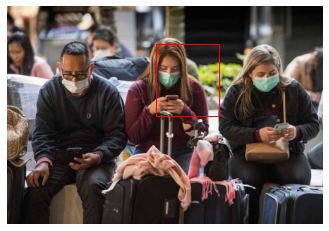

../img/resized/with_mask/image12.png
without_mask 83 %


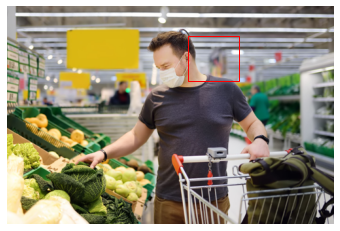

../img/resized/with_mask/image13.png
with_mask 100 %


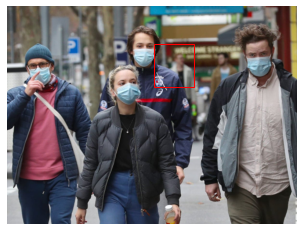

../img/resized/with_mask/image14.png
with_mask 100 %


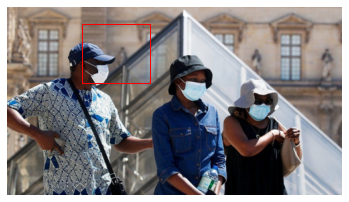

../img/resized/with_mask/image15.png
with_mask 100 %


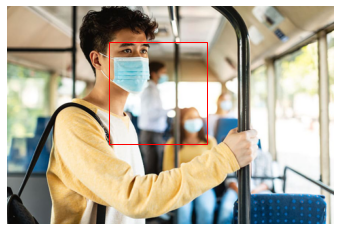

../img/resized/with_mask/image16.png
with_mask 100 %


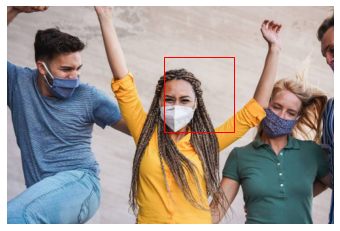

../img/resized/with_mask/image17.png
with_mask 100 %


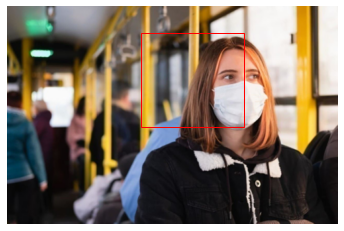

../img/resized/without_mask/image50.png
without_mask 100 %


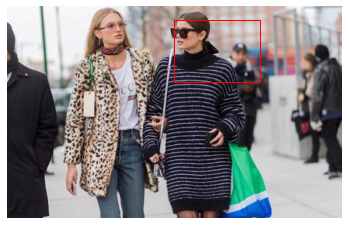

../img/resized/without_mask/image51.png
without_mask 99 %


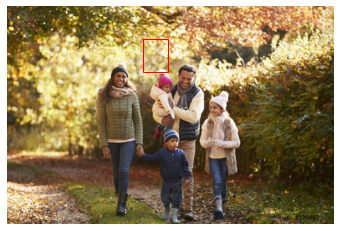

../img/resized/without_mask/image52.png
without_mask 100 %


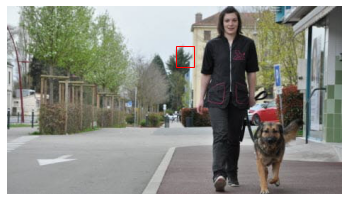

../img/resized/without_mask/image53.png
without_mask 100 %


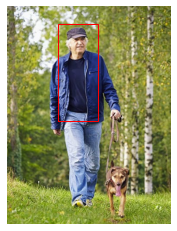

../img/resized/without_mask/image54.png
without_mask 100 %


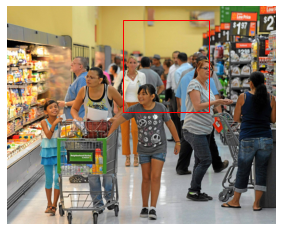

../img/resized/without_mask/image55.png
without_mask 98 %


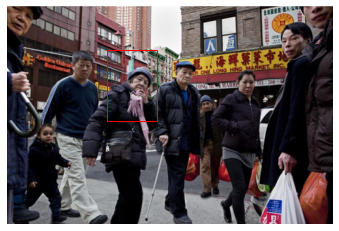

../img/resized/without_mask/image56.png
without_mask 100 %


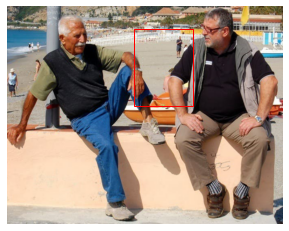

../img/resized/without_mask/image57.png
without_mask 100 %


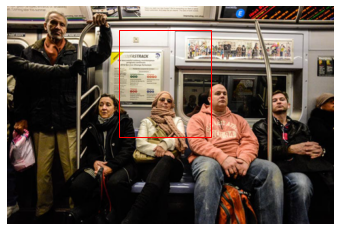

../img/resized/without_mask/image58.png
without_mask 100 %


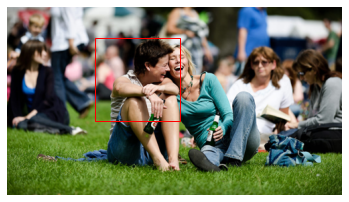

../img/resized/without_mask/image59.png
without_mask 100 %


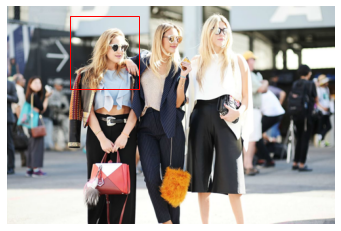

Accuracy :  0.95
Matrice de confusion :
[[ 9  1]
 [ 0 10]]
              precision    recall  f1-score   support

   with_mask       1.00      0.90      0.95        10
without_mask       0.91      1.00      0.95        10

    accuracy                           0.95        20
   macro avg       0.95      0.95      0.95        20
weighted avg       0.95      0.95      0.95        20



In [14]:
predictions = model.predict(validation_images)
predicted_labels = []
#print(predictions)

accuracy = 0

for nb_image in range(len(validation_images)):
    
    fig, ax = plt.subplots()

    img = Image.open(validation_filenames[nb_image]) # On ouvre l'image avec sa taille originale
    print(validation_filenames[nb_image])
    we, he = img.size  # largeur et hauteur de l'image initiale
    ax.imshow(img) # on affiche l'image
    
    classes_predcitions = predictions[0][nb_image] # les prédictions des classes
    boxes_predictions = predictions[1][nb_image] # les prédictions des boites
    
    # On repasse des coordonnées dans [0,1] aux coordonnées dans [largeur image, hauteur image] 
    xmin = boxes_predictions[0] * we 
    ymin = boxes_predictions[1] * he
    xmax = boxes_predictions[2] * we 
    ymax = boxes_predictions[3] * he
    
    w = abs(xmax-xmin) # largeur de la boite
    h = abs(ymax-ymin) # hauteur de la boite
    
    # determination de la categorie : 
    probas = tf.nn.softmax(classes_predcitions)
    pourcentage = int(round(100*np.max(probas), 0))
    category_predicted = categories[np.argmax(probas)] 
    
    predicted_labels.append(np.argmax(probas))

    print(category_predicted, pourcentage, "%")
    
        
    if (np.argmax(probas) == validation_labels[nb_image]):
        accuracy = accuracy + 1

    ax.add_patch(Rectangle((xmin,ymin), w, h,linewidth=1,edgecolor='r',facecolor='none')) # le dessin de la boite
    
    plt.axis('off')  # si on veut enlever les graduations des axes
    plt.show()
    
print("Accuracy : ", accuracy/len(validation_images) )
print("Matrice de confusion :")
print(metrics.confusion_matrix(validation_labels, predicted_labels))
print(metrics.classification_report(validation_labels, predicted_labels,target_names=categories))
